# Tweet Sentiment Extraction

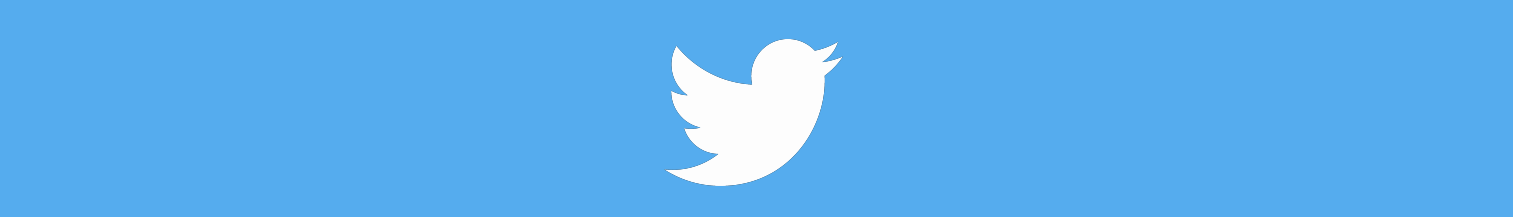


## Overview

This Notebook will be completed in two main ways.<br/>
First, find and visualize useful data or meaningful relationships within the data.<br/>
Second, select a model based on the visualization of the previous process. Transform or refine the data into the appropriate form for the model to be used.<br/><br/>
데이터에 대한 나의 생각 -> 그렇기에 어떤식으로 진행 할 것이다

This competition does not categorize the positive or negative of a sentence, unlike a general emotional analysis competition.<br/>
In the sentence, it was interesting in that it was a contest to extract the sentence that influenced the emotion of the sentence the most.


***

## My workflow
#### 1. Import & Install libray
* Install haversine libray that, a function to find the distance.

#### 2. Check out my data
* Check Shape / Info / Describe

#### 3. Exploratory Data Analysis(EDA) with Visualization [Before Preprocessing]
* Plot the Null Values

#### 4. Prepocessing Data
* Processing Outlier Values
* In this notebook, New York's longitude and latitude are designated as (40.489707, -74.262378) => (40.937760, -73.698009)

#### reference
* https://www.kaggle.com/subinium/tps-apr-highlighting-the-data : EDA(

# 1. Import & Install libray

In [86]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')

%matplotlib inline

In [87]:
import re
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchtext

import tokenizers

import nltk
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [88]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
train_df = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
test_df = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


# 2. Check out my data
* Check Shape / Info

In [5]:
print("Train data size : {}".format(train_df.shape))
print("Test data size : {}".format(test_df.shape))

Train data size : (27481, 4)
Test data size : (3534, 3)


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


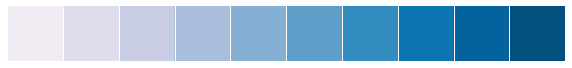

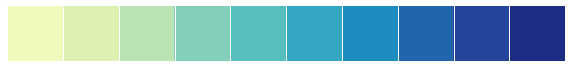

In [7]:
PuBu_palette = sns.color_palette("PuBu", 10)
YlGnBu_palette = sns.color_palette("YlGnBu", 10)
sns.palplot(PuBu_palette)
sns.palplot(YlGnBu_palette)

#### ✔️ This notebook will use this palettes.

# 3. Exploratory Data Analysis(EDA) with Visualization [Before Preprocessing]
* Plot the Null Values

#### 3-1)  Plot the Null Values

In [8]:
pd.DataFrame(train_df.isnull().sum(), columns=["Train Null Count"])

,Train Null Count
textID,0
text,1
selected_text,1
sentiment,0


In [9]:
pd.DataFrame(test_df.isnull().sum(), columns=["Test Null Count"])

,Test Null Count
textID,0
text,0
sentiment,0


<AxesSubplot:>

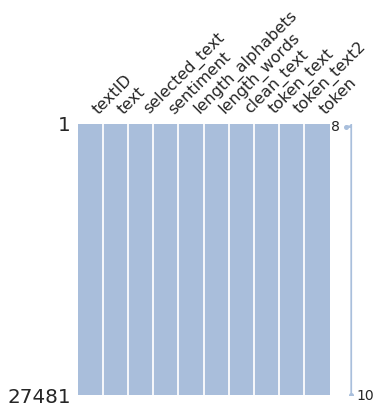

In [162]:
msno.matrix(df=train_df.iloc[:,:],figsize=(5,5),color=PuBu_palette[3])

#### 3-2)  Plot the "sentiment" columns count

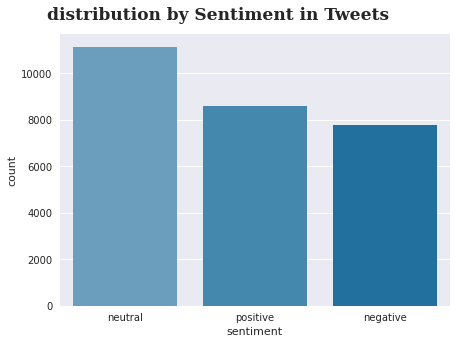

In [11]:
fig, ax = plt.subplots(1,1,figsize=(7, 5))
ax = sns.countplot(train_df["sentiment"].sort_values(ascending=False),
              order = train_df['sentiment'].value_counts().index,
              palette=PuBu_palette[-5:])
fig.text(0.1,0.92,"distribution by Sentiment in Tweets", fontweight="bold", fontfamily='serif', fontsize=17)
plt.show()

#### 3-2) Number of alphabets by sentence / Number of words by sentence

In [12]:
def get_length_alphabets(text):
    text = str(text)
    return len(text)

In [13]:
def get_length_words(text):
    text = str(text)
    return len(text.split(' '))

In [14]:
train_df['length_alphabets'] = train_df['text'].apply(lambda x: get_length_alphabets(x))
train_df['length_words'] = train_df['text'].apply(lambda x: get_length_words(x))
train_df.head()

,textID,text,selected_text,sentiment,length_alphabets,length_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,36,8
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,46,11
2,088c60f138,my boss is bullying me...,bullying me,negative,25,5
3,9642c003ef,what interview! leave me alone,leave me alone,negative,31,6
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,75,15


#### 💡 We can check dataframes describe ([length_alphabets] / [length_words] )

In [15]:
train_df.describe()

,length_alphabets,length_words
count,27481.000000,27481.000000
mean,68.327645,13.779448
std,35.605403,7.169974
min,3.000000,1.000000
25%,39.000000,8.000000
50%,64.000000,13.000000
75%,97.000000,19.000000
max,141.000000,101.000000


In [16]:
PuBu_palette

[(0.946236063052672, 0.9233525567089581, 0.9588465974625143),
 (0.8768319876970396, 0.8676509034986544, 0.928166089965398),
 (0.788558246828143, 0.8066897347174163, 0.8948558246828143),
 (0.6645444059976933, 0.7476355247981545, 0.8623760092272202),
 (0.5256439830834294, 0.691041906958862, 0.8287427912341407),
 (0.36718185313341023, 0.6273740868896578, 0.7905420991926182),
 (0.19594002306805075, 0.5543713956170704, 0.7477739331026528),
 (0.05125720876585929, 0.4598846597462514, 0.7005305651672433),
 (0.017424067666282197, 0.39117262591311036, 0.613763936947328),
 (0.013502499038831219, 0.3158169934640523, 0.4950711264898116)]

In [17]:
three_PuBu_palette = list()
three_PuBu_palette.append(PuBu_palette[2])
three_PuBu_palette.append(PuBu_palette[6])
three_PuBu_palette.append(PuBu_palette[4])
three_PuBu_palette

[(0.788558246828143, 0.8066897347174163, 0.8948558246828143),
 (0.19594002306805075, 0.5543713956170704, 0.7477739331026528),
 (0.5256439830834294, 0.691041906958862, 0.8287427912341407)]

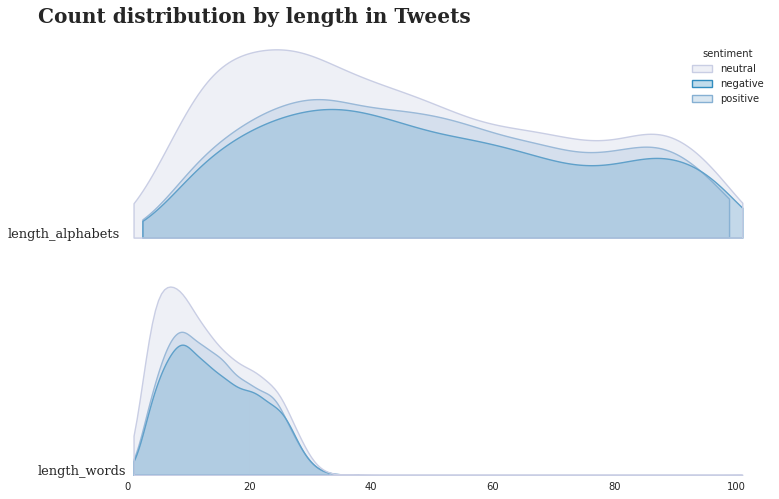

In [18]:
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2,1)

axes = list()

for index, data in zip(range(2), train_df):
    axes.append(fig.add_subplot(gs[index, 0]))
    
    
    if index==0:
        sns.kdeplot(x='length_alphabets', data=train_df, 
                        fill=True, ax=axes[index], cut=0, bw_method=0.20, 
                        lw=1.4 , hue='sentiment', palette=three_PuBu_palette,
                         alpha=0.3)
    else:
        sns.kdeplot(x='length_words', data=train_df, 
                    fill=True, ax=axes[index], cut=0, bw_method=0.20, 
                    lw=1.4 , hue='sentiment',palette=three_PuBu_palette,
                     alpha=0.3) 

    axes[index].set_yticks([])
    if index != 1 : axes[index].set_xticks([])
    axes[index].set_ylabel('')
    axes[index].set_xlabel('')
    axes[index].spines[["top","right","left","bottom"]].set_visible(False)
    
    
    if index == 0:
        axes[index].text(-0.2,0,"length_alphabets",fontweight="light", fontfamily='serif', fontsize=13,ha="right")
    else:
        axes[index].text(-0.2,0,"length_words",fontweight="light", fontfamily='serif', fontsize=13,ha="right")
        
        
    axes[index].patch.set_alpha(0)
    if index != 0 : axes[index].get_legend().remove()
        
fig.text(0.05,0.91,"Count distribution by length in Tweets", fontweight="bold", fontfamily='serif', fontsize=20)
plt.show()

In [97]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

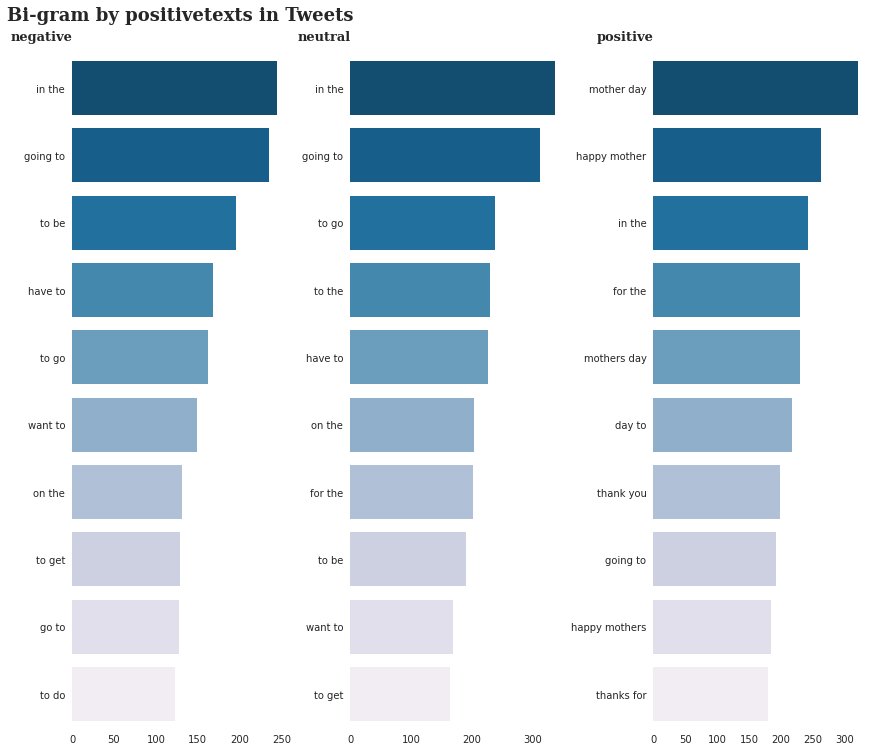

In [159]:
fig, axes = plt.subplots(1,3, figsize=(12, 10), constrained_layout=True)

sentiment_list = list(np.unique(train_df['sentiment']))

for i, sentiment in zip(range(3), sentiment_list):
    top_tweet_bigrams = get_top_tweet_bigrams(train_df[train_df['sentiment']==sentiment]['text'].fillna(" "))[:10]
    x,y = map(list,zip(*top_tweet_bigrams))
    sns.barplot(x=y, y=x, ax=axes[i], palette=PuBu_palette[::-1])
    axes[i].text(0,-0.7, sentiment, fontweight="bold", fontfamily='serif', fontsize=13,ha="right")
    axes[i].patch.set_alpha(0)

fig.text(0,1.01,"Bi-gram by {}texts in Tweets".format(sentiment), fontweight="bold", fontfamily='serif', fontsize=18)
plt.show()

# 4. Prepocessing Data

In [20]:
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

In [32]:
def preprocess_fn(text):
    text = str(text)
    text = text.lower()  # lowercase

    text = re.sub(r'[!]+', '!', text)
    text = re.sub(r'[?]+', '?', text)
    text = re.sub(r'[.]+', '.', text)
    text = re.sub(r"'", "", text)
    text = re.sub('\s+', ' ', text).strip()  # Remove and double spaces
    text = re.sub(r'&amp;?', r'and', text)  # replace & -> and
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text)  # Remove URLs
    # remove some puncts (except . ! # ?)
    text = re.sub(r'[:"$%&\*+,-/:;<=>@\\^_`{|}~]+', '', text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'EMOJI', text)
    
    return text

In [60]:
def tokenize_fn(text):
    text = str(text)
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(lemmatizer.lemmatize(token))
    return " ".join(tokens)

In [66]:
def get_token_fn(text):
    text = str(text)
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(lemmatizer.lemmatize(token))
    return tokens

In [61]:
train_df['clean_text'] = train_df['text'].apply(lambda x: preprocess_fn(x))

In [62]:
train_df['token_text'] = train_df['text'].apply(lambda x: tokenize_fn(x))

In [64]:
train_df['token_text2'] = train_df['clean_text'].apply(lambda x: tokenize_fn(x))

In [69]:
train_df['token'] = train_df['text'].apply(lambda x: get_token_fn(x))

In [70]:
train_df.head()

,textID,text,selected_text,sentiment,length_alphabets,length_words,clean_text,token_text,token_text2,token
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,36,8,id have responded if i were going,"I`d responded, I going",id responded going,"[I`d, responded,, I, going]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,46,11,sooo sad i will miss you here in san diego!,Sooo SAD I miss San Diego!!!,sooo sad miss san diego!,"[Sooo, SAD, I, miss, San, Diego!!!]"
2,088c60f138,my boss is bullying me...,bullying me,negative,25,5,my boss is bullying me,bos bullying me...,bos bullying,"[bos, bullying, me...]"
3,9642c003ef,what interview! leave me alone,leave me alone,negative,31,6,what interview! leave me alone,interview! leave alone,interview! leave alone,"[interview!, leave, alone]"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,75,15,sons of why couldnt they put them on the rele...,"Sons ****, couldn`t put release already bought",son couldnt put release already bought,"[Sons, ****,, couldn`t, put, release, already,..."


In [72]:
train_df['text'][0]

' I`d have responded, if I were going'